In [34]:
# ============================================
# 0. CONFIG
# ============================================
CSV_PATH = "ai4i2020.csv"      # 연습용: ai4i2020.csv
TARGET_COL = "Machine_failure" # 타깃 (0/1)
ID_COL = "UDI"                 # ID 컬럼
CATEGORICAL_COLS = ["Type"]    # 범주형 컬럼들

RANDOM_STATE = 42
TEST_SIZE = 0.2                # train/valid 분할 비율


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
# ============================================
# 13. 오버샘플링: SMOTE 적용 예시
#   - X_train, y_train 기준
#   - Logistic + XGBoost 두 개 다 돌려봄
# ============================================

print("=== Original y_train 분포 ===")
print(y_train.value_counts())

smote = SMOTE(
    sampling_strategy="auto",   # 소수 클래스들을 majority 수준까지
    random_state=RANDOM_STATE,
    k_neighbors=5
)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("\n=== SMOTE 이후 y_train_sm 분포 ===")
print(y_train_sm.value_counts())


In [35]:
# ============================================
# 1. IMPORTS
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
pd.set_option("display.max_columns", 100)


=== Raw Shape === (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

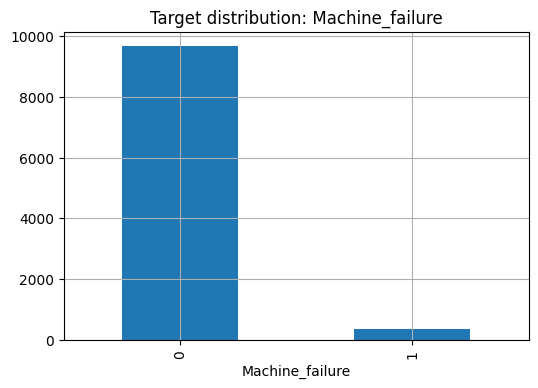

In [36]:
# ============================================
# 2. 데이터 로드 + 컬럼 이름 정리 + 기본 EDA
# ============================================
df_raw = pd.read_csv(CSV_PATH)

print("=== Raw Shape ===", df_raw.shape)
display(df_raw.head())
print(df_raw.info())
print("\n=== Raw Missing values ===")
print(df_raw.isnull().sum())

# 공백, 대괄호, 단위 등을 정리해서 쓰기 편한 이름으로 바꾸자
def clean_column_name(col: str) -> str:
    return (
        col.strip()
           .replace(" ", "_")
           .replace("[", "")
           .replace("]", "")
           .replace("(", "")
           .replace(")", "")
           .replace("/", "_")
           .replace("%", "pct")
           .replace("<", "lt")
           .replace(">", "gt")
    )

df = df_raw.copy()
df.columns = [clean_column_name(c) for c in df.columns]

print("\n=== Cleaned columns ===")
print(df.columns.tolist())

# ai4i2020 기준으로 실제 컬럼들은 대략 이렇게 된다:
# ['UDI', 'Product_ID', 'Type', 'Air_temperature_K', 'Process_temperature_K',
#  'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min',
#  'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# 타깃 분포 확인
print(f"\n=== Target({TARGET_COL}) 분포 ===")
print(df[TARGET_COL].value_counts())
print("\n비율(%)")
print(df[TARGET_COL].value_counts(normalize=True) * 100)

df[TARGET_COL].value_counts().plot(kind="bar")
plt.title(f"Target distribution: {TARGET_COL}")
plt.show()


In [38]:
# ============================================
# 3. 범주형 / 수치형 분리 + 결측/이상치 탐지
# ============================================
# 타깃/ID 제외 피처
feature_cols = [c for c in df.columns if c not in [TARGET_COL, ID_COL]]

# ai4i2020 기준으로 Product_ID도 사실상 ID라서 빼주는 게 안전함
ID_LIKE_COLS = ["Product_ID"]   # 다른 데이터셋이면 여기 수정/추가

feature_cols = [c for c in feature_cols if c not in ID_LIKE_COLS]

X_full = df[feature_cols].copy()
y_full = df[TARGET_COL].copy()

# 1) dtype 기반으로 자동 분리
#    - object/category → 범주형
#    - number → 수치형
cat_cols_auto = X_full.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_auto = X_full.select_dtypes(include=[np.number]).columns.tolist()

# 2) CONFIG에서 지정한 CATEGORICAL_COLS도 포함 (겹치면 자동 dedup)
cat_cols = sorted(set(cat_cols_auto) | set(c for c in CATEGORICAL_COLS if c in X_full.columns))
num_cols = num_cols_auto  # 진짜 숫자 컬럼만

print("범주형 컬럼:", cat_cols)
print("수치형 컬럼:", num_cols)

print("\n=== 결측치 개수 (수치형) ===")
print(X_full[num_cols].isnull().sum())

print("\n=== 결측치 개수 (범주형) ===")
print(X_full[cat_cols].isnull().sum())

# IQR 기반 간단 이상치 개수 확인 (숫자 컬럼만)
def detect_outliers_iqr(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).sum()

print("\n=== 이상치 개수(IQR 기준) ===")
for col in num_cols:
    n_out = detect_outliers_iqr(X_full[col])
    print(f"{col}: {n_out}")


범주형 컬럼: ['Type']
수치형 컬럼: ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

=== 결측치 개수 (수치형) ===
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Tool_wear_min            0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64

=== 결측치 개수 (범주형) ===
Type    0
dtype: int64

=== 이상치 개수(IQR 기준) ===
Air_temperature_K: 0
Process_temperature_K: 0
Rotational_speed_rpm: 418
Torque_Nm: 69
Tool_wear_min: 0
TWF: 46
HDF: 115
PWF: 95
OSF: 98
RNF: 19


In [39]:
# ============================================
# 4. 전처리
#   - 결측치 처리
#   - 이상치 클리핑
#   - 수치형 스케일링
#   - 범주형 원-핫 인코딩
#   - PCA latent feature
# ============================================

# 4-1) 결측치 처리
X_num = X_full[num_cols].copy()
X_cat = X_full[cat_cols].copy()

# 수치형: median 대체
X_num_imputed = X_num.fillna(X_num.median())

# 범주형: "Unknown" 대체
X_cat_imputed = X_cat.fillna("Unknown")

# 4-2) 이상치 처리: 1% ~ 99% 구간으로 클리핑
for col in num_cols:
    lower = X_num_imputed[col].quantile(0.01)
    upper = X_num_imputed[col].quantile(0.99)
    X_num_imputed[col] = X_num_imputed[col].clip(lower, upper)

# 4-3) 수치형 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_imputed),
    columns=num_cols,
    index=X_num_imputed.index,
)

# 4-4) 범주형 원-핫 인코딩
X_cat_oh = pd.get_dummies(X_cat_imputed, columns=cat_cols, drop_first=True)

print("X_num_scaled shape:", X_num_scaled.shape)
print("X_cat_oh shape:", X_cat_oh.shape)


X_num_scaled shape: (10000, 10)
X_cat_oh shape: (10000, 2)


In [40]:
# 4-5) 비지도 학습: PCA로 latent feature 생성
if len(num_cols) > 0:
    n_components = min(3, len(num_cols))  # 수치형이 적으면 그만큼만
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_components = pca.fit_transform(X_num_scaled)

    X_pca = pd.DataFrame(
        pca_components,
        columns=[f"pca_{i+1}" for i in range(n_components)],
        index=X_num_scaled.index,
    )

    print("PCA explained variance ratio:", pca.explained_variance_ratio_)
    print("X_pca shape:", X_pca.shape)
else:
    X_pca = pd.DataFrame(index=X_num_scaled.index)
    print("수치형 피처가 없어서 PCA 스킵")

# 4-6) 최종 피처 결합
X_all = pd.concat([X_num_scaled, X_cat_oh, X_pca], axis=1)
print("최종 피처 shape:", X_all.shape)


PCA explained variance ratio: [0.32237615 0.31599521 0.16663078]
X_pca shape: (10000, 3)
최종 피처 shape: (10000, 15)


In [41]:
# ============================================
# 5. train/valid 분할 (불균형 유지: stratify)
# ============================================

X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_full,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_full
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("\n=== y_train 분포 ===")
print(y_train.value_counts())
print("\n=== y_valid 분포 ===")
print(y_valid.value_counts())


X_train shape: (8000, 15)
X_valid shape: (2000, 15)

=== y_train 분포 ===
Machine_failure
0    7729
1     271
Name: count, dtype: int64

=== y_valid 분포 ===
Machine_failure
0    1932
1      68
Name: count, dtype: int64


In [42]:
# ============================================
# 6. 평가 함수 (이진 분류용)
#   - Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
#   - Confusion Matrix, Classification Report
# ============================================
def eval_classifier(y_true, y_pred, y_proba=None, print_report=True):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    if y_proba is not None:
        try:
            roc = roc_auc_score(y_true, y_proba)
        except ValueError:
            roc = np.nan
        prauc = average_precision_score(y_true, y_proba)
        metrics["roc_auc"] = roc
        metrics["pr_auc"] = prauc

    if print_report:
        print("Accuracy :", acc)
        print("Precision:", prec)
        print("Recall   :", rec)
        print("F1       :", f1)
        if y_proba is not None:
            print("ROC-AUC :", metrics["roc_auc"])
            print("PR-AUC  :", metrics["pr_auc"])
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, zero_division=0))

    return metrics


In [43]:
# ============================================
# 7. 모델 학습
#   7-1) Logistic Regression (class_weight='balanced')
#   7-2) XGBoost (scale_pos_weight)
# ============================================

# 7-1) 불균형 대응 Logistic Regression
print("=== Logistic Regression (class_weight='balanced') ===")
log_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)
log_clf.fit(X_train, y_train)
y_pred_log  = log_clf.predict(X_valid)
y_proba_log = log_clf.predict_proba(X_valid)[:, 1]
metrics_log = eval_classifier(y_valid, y_pred_log, y_proba_log)


=== Logistic Regression (class_weight='balanced') ===
Accuracy : 0.8755
Precision: 0.19732441471571907
Recall   : 0.8676470588235294
F1       : 0.3215258855585831
ROC-AUC : 0.9482097186700768
PR-AUC  : 0.7375752836721245

Confusion Matrix:
[[1692  240]
 [   9   59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1932
           1       0.20      0.87      0.32        68

    accuracy                           0.88      2000
   macro avg       0.60      0.87      0.63      2000
weighted avg       0.97      0.88      0.91      2000



In [44]:
# 7-2) XGBoost: 불균형 대응 scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("\nscale_pos_weight:", pos_weight)

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",   # 최신 버전에서는 이것만 설정해도 됨
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb  = xgb_clf.predict(X_valid)
y_proba_xgb = xgb_clf.predict_proba(X_valid)[:, 1]
metrics_xgb = eval_classifier(y_valid, y_pred_xgb, y_proba_xgb)



scale_pos_weight: 28.52029520295203
Accuracy : 0.9765
Precision: 0.6206896551724138
Recall   : 0.7941176470588235
F1       : 0.6967741935483871
ROC-AUC : 0.9774464133479479
PR-AUC  : 0.8486035253546163

Confusion Matrix:
[[1899   33]
 [  14   54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.62      0.79      0.70        68

    accuracy                           0.98      2000
   macro avg       0.81      0.89      0.84      2000
weighted avg       0.98      0.98      0.98      2000



In [45]:
# ============================================
# 8. Threshold 탐색 (지표 최적화)
#   - 여러 threshold에 대해 Precision/Recall/F1 계산
#   - F1 기준 최적 threshold 선택
# ============================================
thresholds = np.arange(0.05, 0.96, 0.05)

rows = []
for th in thresholds:
    y_pred_th = (y_proba_xgb >= th).astype(int)
    m = eval_classifier(y_valid, y_pred_th, y_proba_xgb, print_report=False)
    m["threshold"] = th
    rows.append(m)

th_df = pd.DataFrame(rows).set_index("threshold")
print("=== Threshold vs Metrics (XGBoost) ===")
display(th_df)

# F1 기준 최적 threshold
best_th = th_df["f1"].idxmax()
print("\n=== Best threshold (by F1) ===", best_th)
print(th_df.loc[best_th])

print("\n=== Metrics @ best threshold ===")
y_pred_best = (y_proba_xgb >= best_th).astype(int)
metrics_best = eval_classifier(y_valid, y_pred_best, y_proba_xgb)


=== Threshold vs Metrics (XGBoost) ===


,accuracy,precision,recall,f1,roc_auc,pr_auc
threshold,,,,,,
0.05,0.9285,0.313433,0.926471,0.468401,0.977446,0.848604
0.10,0.9495,0.396226,0.926471,0.555066,0.977446,0.848604
0.15,0.9580,0.442857,0.911765,0.596154,0.977446,0.848604
0.20,0.9645,0.487805,0.882353,0.628272,0.977446,0.848604
0.25,0.9680,0.517544,0.867647,0.648352,0.977446,0.848604
0.30,0.9700,0.537037,0.852941,0.659091,0.977446,0.848604
0.35,0.9735,0.574257,0.852941,0.686391,0.977446,0.848604
0.40,0.9740,0.583333,0.823529,0.682927,0.977446,0.848604
0.45,0.9765,0.615385,0.823529,0.704403,0.977446,0.848604



=== Best threshold (by F1) === 0.8
accuracy     0.988000
precision    0.923077
recall       0.705882
f1           0.800000
roc_auc      0.977446
pr_auc       0.848604
Name: 0.8, dtype: float64

=== Metrics @ best threshold ===
Accuracy : 0.988
Precision: 0.9230769230769231
Recall   : 0.7058823529411765
F1       : 0.8
ROC-AUC : 0.9774464133479479
PR-AUC  : 0.8486035253546163

Confusion Matrix:
[[1928    4]
 [  20   48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.92      0.71      0.80        68

    accuracy                           0.99      2000
   macro avg       0.96      0.85      0.90      2000
weighted avg       0.99      0.99      0.99      2000



In [46]:
# ============================================
# 9. 만능 리포트 함수
#   - 상위 p%, 상위 N개, threshold 기준
#   - 전체 / 그룹별 (예: Type별)
# ============================================
def make_rank_report(
    df,                  # 원본 df (검증셋 인덱스로 필터된 상태 추천)
    score,               # 1D array-like, 이상/리스크 score (클수록 이상)
    id_cols,             # 항상 보고 싶을 ID/기본 컬럼 리스트
    extra_cols=None,     # 추가 정보 컬럼 리스트
    k_ratio=None,        # 상위 비율 (예: 0.05)
    k_abs=None,          # 상위 개수 (예: 100)
    threshold=None,      # score threshold (예: 0.8)
    group_col=None,      # 그룹별 상위 (예: 'Type')
    max_rows=30          # 최종 출력 최대 행 수
):
    """
    다양한 '상위 x%, N개, threshold, 그룹별' 리포트를 공통으로 만드는 함수
    """

    tmp = df.copy()
    tmp["score"] = score

    base_cols = list(id_cols)
    if extra_cols is not None:
        base_cols += list(extra_cols)
    base_cols = [c for c in base_cols if c in tmp.columns] + ["score"]

    # ---- 1) 그룹별 리포트 ----
    if group_col is not None and group_col in tmp.columns:
        reports = []
        for g, g_df in tmp.groupby(group_col):
            g_sorted = g_df.sort_values("score", ascending=False)

            if threshold is not None:
                g_sel = g_sorted[g_sorted["score"] >= threshold]
            elif k_abs is not None:
                g_sel = g_sorted.head(k_abs)
            elif k_ratio is not None:
                k = max(1, int(len(g_sorted) * k_ratio))
                g_sel = g_sorted.head(k)
            else:
                g_sel = g_sorted.head(max_rows)

            g_sel = g_sel[base_cols].head(max_rows)
            g_sel[group_col] = g
            reports.append(g_sel)

        if len(reports) == 0:
            return pd.DataFrame(columns=base_cols + [group_col])

        report_df = pd.concat(reports, axis=0)
        report_df = report_df.sort_values("score", ascending=False)
        return report_df.head(max_rows)

    # ---- 2) 전체 기준 리포트 ----
    tmp_sorted = tmp.sort_values("score", ascending=False)

    if threshold is not None:
        sel = tmp_sorted[tmp_sorted["score"] >= threshold]
    elif k_abs is not None:
        sel = tmp_sorted.head(k_abs)
    elif k_ratio is not None:
        k = max(1, int(len(tmp_sorted) * k_ratio))
        sel = tmp_sorted.head(k)
    else:
        sel = tmp_sorted.head(max_rows)

    return sel[base_cols].head(max_rows)


In [47]:
# ============================================
# 10. 리포트 예시 1: 상위 5% (최대 30건)
#   - ai4i 기준: UDI, Type, Torque_Nm, Tool_wear_min, score, Machine_failure
# ============================================
valid_index = X_valid.index
df_valid = df.loc[valid_index].copy()

report_top5 = make_rank_report(
    df=df_valid,
    score=y_proba_xgb,   # 불량(1) 예측 확률
    id_cols=[ID_COL],
    extra_cols=["Type", "Torque_Nm", "Tool_wear_min", TARGET_COL],
    k_ratio=0.05,        # 상위 5%
    max_rows=30
)

print("=== XGBoost: 상위 5% (최대 30건) 이상 샘플 리포트 ===")
display(report_top5)


=== XGBoost: 상위 5% (최대 30건) 이상 샘플 리포트 ===


,UDI,Type,Torque_Nm,Tool_wear_min,Machine_failure,score
4601,4602,M,54.3,117,1,0.999716
4170,4171,M,51.5,126,1,0.999661
4661,4662,L,48.1,32,1,0.999650
4600,4601,L,44.2,115,1,0.999576
4179,4180,L,46.1,148,1,0.999498
4427,4428,M,48.9,107,1,0.999491
4270,4271,L,52.0,154,1,0.999440
4080,4081,L,58.0,108,1,0.999436
4130,4131,L,62.8,22,1,0.999432
4495,4496,L,57.2,67,1,0.999431


In [48]:
# ============================================
# 11. 리포트 예시 2: threshold 0.9 이상 (최대 50건)
# ============================================
report_th09 = make_rank_report(
    df=df_valid,
    score=y_proba_xgb,
    id_cols=[ID_COL],
    extra_cols=["Type", "Torque_Nm", "Tool_wear_min", TARGET_COL],
    threshold=0.9,
    max_rows=50
)

print("=== XGBoost: score >= 0.9 (최대 50건) 리포트 ===")
display(report_th09)


=== XGBoost: score >= 0.9 (최대 50건) 리포트 ===


,UDI,Type,Torque_Nm,Tool_wear_min,Machine_failure,score
4601,4602,M,54.3,117,1,0.999716
4170,4171,M,51.5,126,1,0.999661
4661,4662,L,48.1,32,1,0.999650
4600,4601,L,44.2,115,1,0.999576
4179,4180,L,46.1,148,1,0.999498
4427,4428,M,48.9,107,1,0.999491
4270,4271,L,52.0,154,1,0.999440
4080,4081,L,58.0,108,1,0.999436
4130,4131,L,62.8,22,1,0.999432
4495,4496,L,57.2,67,1,0.999431


In [49]:
# ============================================
# 12. 리포트 예시 3: Type별 상위 10개 (그룹별 랭킹)
# ============================================
report_by_type = make_rank_report(
    df=df_valid,
    score=y_proba_xgb,
    id_cols=[ID_COL],
    extra_cols=[TARGET_COL],
    k_abs=10,           # 각 Type별 상위 10개
    group_col="Type",
    max_rows=100
)

print("=== XGBoost: Type별 상위 10개 이상 샘플 ===")
display(report_by_type)


=== XGBoost: Type별 상위 10개 이상 샘플 ===


,UDI,Machine_failure,score,Type
4601,4602,1,0.999716,M
4170,4171,1,0.999661,M
4661,4662,1,0.999650,L
4600,4601,1,0.999576,L
4179,4180,1,0.999498,L
4427,4428,1,0.999491,M
4270,4271,1,0.999440,L
4080,4081,1,0.999436,L
4130,4131,1,0.999432,L
4495,4496,1,0.999431,L


In [51]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
# ============================================
# 13. 오버샘플링: SMOTE 적용 예시
#   - X_train, y_train 기준
#   - Logistic + XGBoost 두 개 다 돌려봄
# ============================================

print("=== Original y_train 분포 ===")
print(y_train.value_counts())

smote = SMOTE(
    sampling_strategy="auto",   # 소수 클래스들을 majority 수준까지
    random_state=RANDOM_STATE,
    k_neighbors=5
)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("\n=== SMOTE 이후 y_train_sm 분포 ===")
print(y_train_sm.value_counts())



=== Original y_train 분포 ===
Machine_failure
0    7729
1     271
Name: count, dtype: int64

=== SMOTE 이후 y_train_sm 분포 ===
Machine_failure
0    7729
1    7729
Name: count, dtype: int64


In [52]:
# 13-1) SMOTE + LogisticRegression (class_weight 없이도 사용 가능)
print("\n=== Logistic Regression (SMOTE oversampled) ===")
log_clf_sm = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    # 여기서는 굳이 class_weight='balanced' 안 써도 됨
)
log_clf_sm.fit(X_train_sm, y_train_sm)

y_pred_log_sm  = log_clf_sm.predict(X_valid)
y_proba_log_sm = log_clf_sm.predict_proba(X_valid)[:, 1]

metrics_log_sm = eval_classifier(y_valid, y_pred_log_sm, y_proba_log_sm)



=== Logistic Regression (SMOTE oversampled) ===
Accuracy : 0.8985
Precision: 0.23107569721115537
Recall   : 0.8529411764705882
F1       : 0.36363636363636365
ROC-AUC : 0.9428815004262575
PR-AUC  : 0.7365569393569729

Confusion Matrix:
[[1739  193]
 [  10   58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1932
           1       0.23      0.85      0.36        68

    accuracy                           0.90      2000
   macro avg       0.61      0.88      0.65      2000
weighted avg       0.97      0.90      0.93      2000



In [53]:
# 13-2) SMOTE + XGBoost (scale_pos_weight 없이 단순 oversampling)
print("\n=== XGBoost (SMOTE oversampled) ===")
xgb_clf_sm = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    # SMOTE로 클래스 균형 맞췄으니 scale_pos_weight는 생략
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
)
xgb_clf_sm.fit(X_train_sm, y_train_sm)

y_pred_xgb_sm  = xgb_clf_sm.predict(X_valid)
y_proba_xgb_sm = xgb_clf_sm.predict_proba(X_valid)[:, 1]

metrics_xgb_sm = eval_classifier(y_valid, y_pred_xgb_sm, y_proba_xgb_sm)



=== XGBoost (SMOTE oversampled) ===
Accuracy : 0.968
Precision: 0.5178571428571429
Recall   : 0.8529411764705882
F1       : 0.6444444444444445
ROC-AUC : 0.97788789428815
PR-AUC  : 0.8289306050135405

Confusion Matrix:
[[1878   54]
 [  10   58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.52      0.85      0.64        68

    accuracy                           0.97      2000
   macro avg       0.76      0.91      0.81      2000
weighted avg       0.98      0.97      0.97      2000



In [54]:
import shap

# 노트북에서 예쁘게 그리기
shap.initjs()


In [55]:
# ============================================
# 14. SHAP으로 XGBoost 모델 해석
#   - 검증셋 일부 샘플만 사용 (예: 최대 500개)
# ============================================
# X_valid, y_valid, xgb_clf, X_all 가 이미 정의되어 있다고 가정

# DataFrame 형태 유지 (컬럼 이름 포함)
X_valid_df = X_valid.copy()

# 샘플 줄이기
X_valid_sample = X_valid_df.sample(
    n=min(500, len(X_valid_df)),
    random_state=RANDOM_STATE
)

print("X_valid_sample shape:", X_valid_sample.shape)


X_valid_sample shape: (500, 15)


In [56]:
# 트리 기반 모델(XGBoost)에 적합한 Explainer
explainer = shap.TreeExplainer(xgb_clf)

shap_values = explainer.shap_values(X_valid_sample)

# binary일 때 shap_values 형식이 shap 버전에 따라 다를 수 있으니 방어적으로 처리
if isinstance(shap_values, list):
    # list인 경우: [class0, class1] → 양성 클래스(1)에 대한 값 사용
    shap_values_binary = shap_values[1]
else:
    shap_values_binary = shap_values  # (n_samples, n_features)

shap_values_binary.shape


(500, 15)

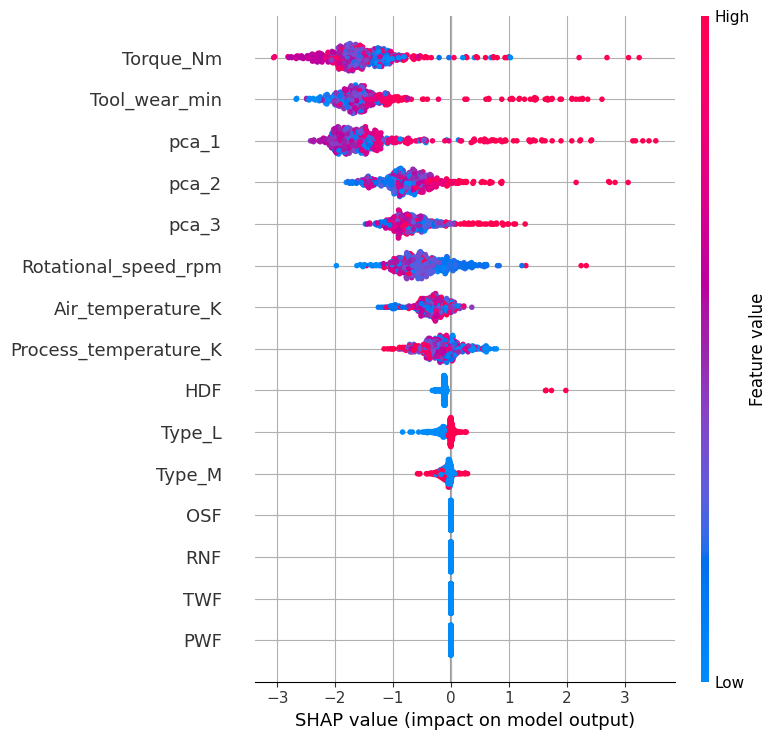

In [57]:
# Summary plot: 어떤 피처들이 전반적으로 영향을 많이 미치는지
shap.summary_plot(
    shap_values_binary,
    X_valid_sample,
    feature_names=X_valid_sample.columns,
    show=True
)


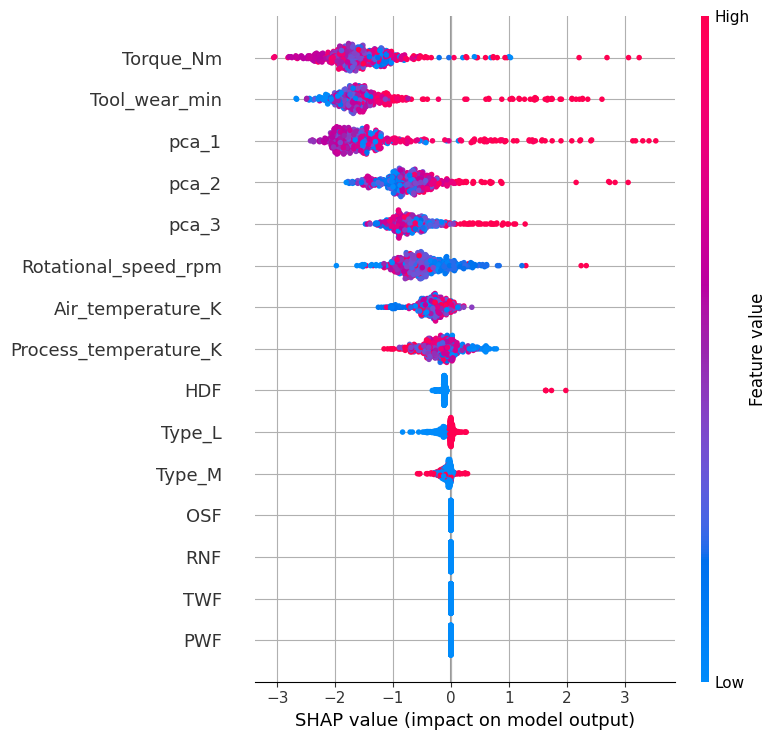

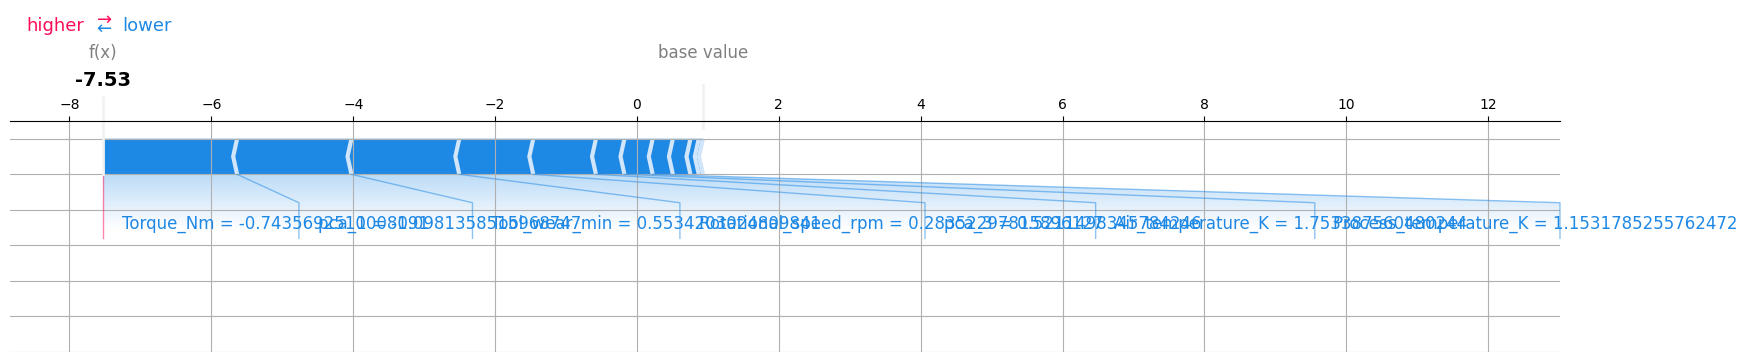

In [58]:
# Summary plot: 어떤 피처들이 전반적으로 영향을 많이 미치는지
shap.summary_plot(
    shap_values_binary,
    X_valid_sample,
    feature_names=X_valid_sample.columns,
    show=True
)
# 예시: 첫 번째 샘플 하나 pick
i = 0
shap.force_plot(
    explainer.expected_value,
    shap_values_binary[i, :],
    X_valid_sample.iloc[i, :],
    matplotlib=True
)
